### Starting to think a bit about trends.
1. compute some regionally-averaged metric (surface chl, NPP, etc.) 
2. plot its timeseries, 1920-2100. 
* start with the single run
* expand to include the full ensemble

I can help if you get stuck. Don't flounder around too long before asking for help.

In [1]:
%matplotlib inline
import os
import importlib
import pandas as pd
import numpy as np
import xarray as xr
import calendar
import cftime

import xesmf as xe
import dask
from ncar_jobqueue import NCARCluster
import esmlab
import warnings
warnings.filterwarnings('ignore')
from glob import glob
from collections import OrderedDict

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.path as mpath

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats

import util
import shutil

In [2]:
from ncar_jobqueue import NCARCluster
#cluster = NCARCluster()
cluster = NCARCluster(project='UCUC0006')
cluster.scale(36) #adapt(minimum_jobs=1, maximum_jobs=40)
cluster

In [3]:
from dask.distributed import Client
client = Client(cluster) # Connect this local process to remote workers
client

Client Scheduler: tcp://128.117.181.211:37349 Dashboard: https://jupyterhub.ucar.edu/dav/user/zephyrs/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [41]:
cesmle_root = '/glade/p/cesm/community/CESM-LE/data/CESM-CAM5-BGC-LE'

component = 'ocn'
freq = 'monthly'
stream = 'pop.h' # POP ocean model monthly stream
case = 'b.e11.B20TRC5CNBDRD.f09_g16.001'

variables = ['SST', 'diatChl', 'spChl', 'diazChl']
grid_vars = ['KMT', 'TAREA', 'TLAT', 'TLONG', 'z_t', 'dz', 'z_t_150m', 'time', 'time_bound']

# loop over variables, construct list of datasets
ds_list = []
for v in variables:
    files = glob(f'{cesmle_root}/{component}/proc/tseries/{freq}/{v}/{case}.{stream}.{v}.*.nc')
    dsi = xr.open_mfdataset(files, decode_coords=False, decode_times=False, 
                            concat_dim='time',
                            combine='nested',
                            data_vars=[v],
                            chunks={'nlon': 16})
    # SST has a singleton z_t dimension, so remove this to avoid problems on merge
    if v == 'SST':
        dsi = dsi.squeeze(dim='z_t', drop=True).drop('dz')
        
        
    ds_list.append(dsi)
    
ds = xr.merge(ds_list)
ds = ds[variables+grid_vars]

ds['time'] = xr.DataArray(cftime.num2date(ds.time_bound.mean(dim='d2'), units=ds.time.units, 
                                         calendar=ds.time.calendar), dims=('time'))

ds['Chl_surf'] = (ds.diatChl + ds.spChl + ds.diazChl).isel(z_t_150m=0)
ds.Chl_surf.attrs = ds.diatChl.attrs
ds.Chl_surf.attrs['long_name'] = 'Surface chlorophyll'

variables = list(filter(lambda v: 'Chl' not in v, variables)) + ['Chl_surf']
ds = ds[variables+grid_vars]
ds

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 1872, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t         (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m    (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * time        (time) object 1850-01-17 00:30:00 ... 2005-12-16 12:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    SST         (time, nlat, nlon) float32 dask.array<chunksize=(1872, 384, 16), meta=np.ndarray>
    Chl_surf    (time, nlat, nlon) float32 dask.array<chunksize=(1872, 384, 16), meta=np.ndarray>
    KMT         (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TAREA       (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    dz          (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    time_bound  (time, d2) float64 dask.array<chunksize=(1872, 2), meta=np.ndarray>

In [42]:
variables = ['SST', 'Chl_surf', 'KMT', 'TAREA', 'TLAT', 'TLONG', 'z_t', 'dz', 'z_t_150m', 'time_bound',]

In [55]:
## Clip to proper time: 1920 - end:
#ds = ds[variables].isel(time=slice(1632, 1872)).groupby('time.month').mean('time')
ds = ds[variables].isel(time=slice(840, 1872))

In [56]:
#Create a mask
masked_area = ds.TAREA.where((ds.TLAT <= -45) & (ds.KMT > 0))
masked_area

<xarray.DataArray 'TAREA' (nlat: 384, nlon: 320)>
dask.array<where, shape=(384, 320), dtype=float64, chunksize=(384, 16), chunktype=numpy.ndarray>
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:    area of T cells
    units:        centimeter^2
    coordinates:  TLONG TLAT

## Create Regionalized Data

In [45]:
# Pull in the grid:
grid_name = 'POP_gx1v7'
grid = pop_tools.get_grid(grid_name)

In [46]:
# Set it up:
lat = grid.TLAT
lon = grid.TLONG

In [47]:
# Mask out rectangles:
mask_SO_atl = (lat <= -45) & ((lon >= 298) | (lon <= 20))
mask_SO_ind = (lat <= -45) & (lon > 20) & (lon <= 145)
mask_SO_pac = (lat <= -45) & (lon > 145) & (lon <= 298)
mask_SO = (lat <= -45)

In [ ]:
sst_so_mean = (ds.SST * masked_area).sum(['nlat', 'nlon']) / masked_area.sum(['nlat', 'nlon'])
sst_so_mean = sst_so_mean.compute()

sst_ind_mean = (ds.SST * mask_SO_ind).sum(['nlat', 'nlon']) / mask_SO_ind.sum(['nlat', 'nlon'])
sst_ind_mean = sst_ind_mean.compute()

sst_atl_mean = (ds.SST * mask_SO_atl).sum(['nlat', 'nlon']) / mask_SO_atl.sum(['nlat', 'nlon'])
sst_atl_mean = sst_atl_mean.compute()

sst_pac_mean = (ds.SST * mask_SO_pac).sum(['nlat', 'nlon']) / mask_SO_pac.sum(['nlat', 'nlon'])
sst_pac_mean = sst_pac_mean.compute()

### Plot Chl
style.use('ggplot')
sns.set_style("darkgrid")

In [107]:
import seaborn as sns
#sns.set_style("darkgrid")
#style.use('seaborn')
#style.use('ggplot')

NameError: name 'pwd' is not defined

In [109]:
#for saving figures:
pwd = os.getcwd()
os.chdir('/glade/u/home/zephyrs/projects/krill-cesm-le/figures')
pwd

'/glade/u/home/zephyrs/projects/krill-cesm-le/notebooks'

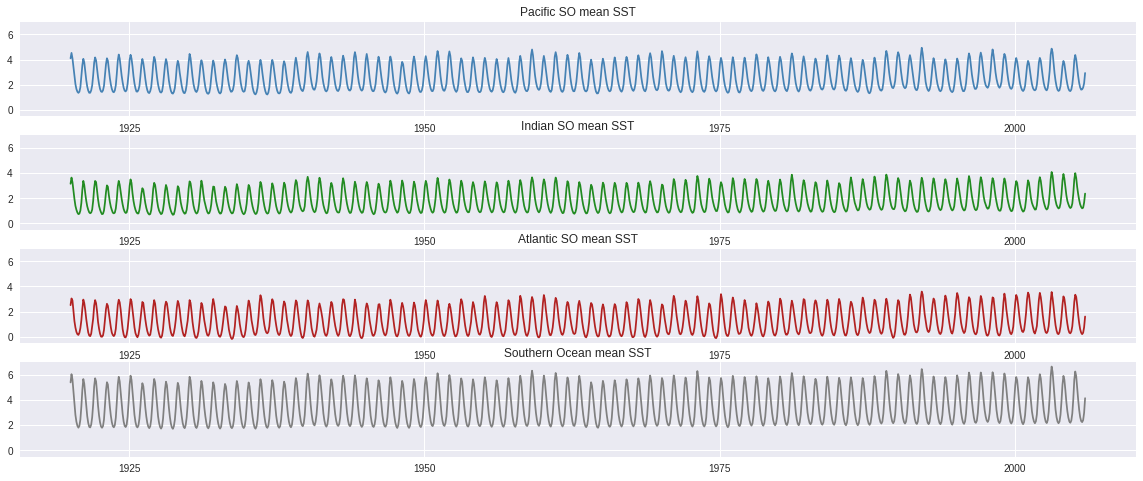

In [139]:
# Plot all Basins
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(411)
ax1.set_title('Pacific SO mean SST')
ax1.plot(sst_pac_mean['time'].values, sst_pac_mean.values, color = 'steelblue')
plt.gca()

ax2 = fig.add_subplot(412,sharex=ax1, sharey=ax1 )
ax2.set_title('Indian SO mean SST')
ax2.plot(sst_ind_mean['time'].values, sst_ind_mean.values, color = 'forestgreen')
plt.gca()


ax3 = fig.add_subplot(413,sharex=ax1, sharey=ax1)
ax3.set_title('Atlantic SO mean SST')
ax3.plot(sst_atl_mean['time'].values, sst_atl_mean.values, color = 'firebrick')
plt.gca()

ax3 = fig.add_subplot(414, sharex=ax1, sharey=ax1)
ax3.set_title('Southern Ocean mean SST')
ax3.plot(sst_so_mean['time'].values, sst_so_mean.values, color = 'grey')
plt.gca()

#plt.savefig('CESM-SST-TIMESERIES-BYBASIN-INDIVID.png')

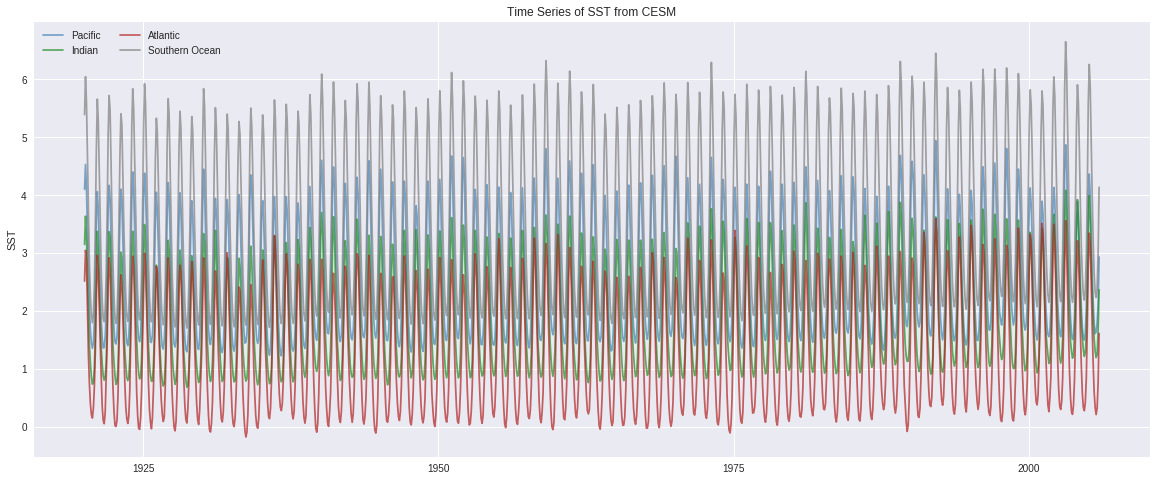

In [138]:
# Plot all Basins
fig = plt.figure(figsize=(20,8))

ax = fig.add_subplot(111)
ax.set_title('Time Series of SST from CESM')

ax.plot(sst_pac_mean['time'].values, sst_pac_mean.values, alpha=0.7, label = 'Pacific', color = 'steelblue')
ax.plot(sst_ind_mean['time'].values, sst_ind_mean.values, alpha=0.7, label = 'Indian', color = 'forestgreen')
ax.plot(sst_atl_mean['time'].values, sst_atl_mean.values, alpha=0.7, label = 'Atlantic', color = 'firebrick')
ax.plot(sst_so_mean['time'].values, sst_so_mean.values, alpha=0.7, label = 'Southern Ocean', color = 'grey')

ax.legend(ncol=2)
ax.set(ylabel='SST')
plt.gca()

#plt.savefig('CESM-SST-TIMESERIES-BYBASIN.png')

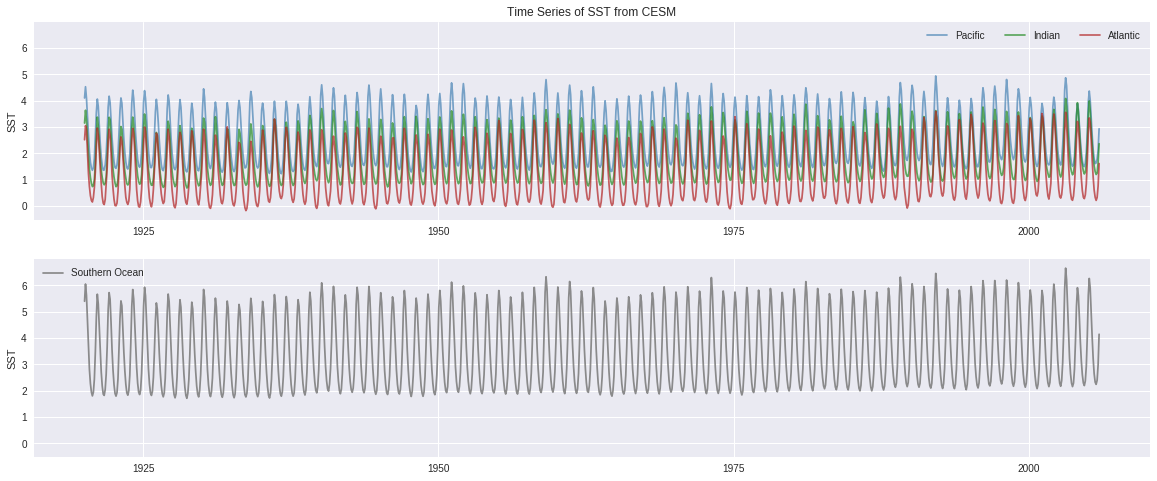

In [149]:
# Plot all Basins
style.use('seaborn')

fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(211)
ax1.set_title('Time Series of SST from CESM')

ax1.plot(sst_pac_mean['time'].values, sst_pac_mean.values, alpha=0.7, label = 'Pacific', color = "steelblue")
ax1.plot(sst_ind_mean['time'].values, sst_ind_mean.values, alpha=0.7, label = 'Indian', color = "forestgreen")
ax1.plot(sst_atl_mean['time'].values, sst_atl_mean.values, alpha=0.7, label = 'Atlantic', color = "firebrick")

ax1.legend(ncol=3)
ax1.set(ylabel='SST')
plt.gca()

ax2 = fig.add_subplot(212, sharex=ax1, sharey=ax1 )
ax2.plot(sst_so_mean['time'].values, sst_so_mean.values, alpha=0.9, label = 'Southern Ocean', color = "grey")
ax2.legend()
ax2.set(ylabel='SST')
plt.gca()

#plt.savefig('CESM-SST-TIMESERIES-BYBASIN-SOsepate.png')

In [2]:
'''
# Create regional weighted means
#Pacific - CESM
ds_pac = ds.Chl_surf.where(mask_SO_pac)
ds_pac['Chl_surf']= esmlab.weighted_mean(ds['Chl_surf']*ds.TAREA.where(mask_SO_pac),
                                         weights=ds.TAREA, dim=['nlat', 'nlon']).compute()

#Atlantic - CESM
ds_atl = ds.Chl_surf.where(mask_SO_atl)
ds_atl['Chl_surf']= esmlab.weighted_mean(ds['Chl_surf']*ds.TAREA.where(mask_SO_atl),
                                         weights=ds.TAREA, dim=['nlat', 'nlon']).compute()

#Indian - CESM
ds_ind = ds.Chl_surf.where(mask_SO_ind)
ds_ind['Chl_surf']= esmlab.weighted_mean(ds['Chl_surf']*ds.TAREA.where(mask_SO_ind),
                                         weights=ds.TAREA, dim=['nlat', 'nlon']).compute()

#SOUTHERN OCEAN - CESM
ds_so = ds.Chl_surf.where(mask_SO)
ds_so['Chl_surf']= esmlab.weighted_mean(ds['Chl_surf']*ds.TAREA.where(mask_SO),
                                         weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
''';

In [114]:
chl_so_mean = (ds.Chl_surf * masked_area).sum(['nlat', 'nlon']) / masked_area.sum(['nlat', 'nlon'])
chl_so_mean = chl_so_mean.compute()

chl_ind_mean = (ds.Chl_surf * mask_SO_ind).sum(['nlat', 'nlon']) / mask_SO_ind.sum(['nlat', 'nlon'])
chl_ind_mean = chl_ind_mean.compute()

chl_atl_mean = (ds.Chl_surf * mask_SO_atl).sum(['nlat', 'nlon']) / mask_SO_atl.sum(['nlat', 'nlon'])
chl_atl_mean = chl_atl_mean.compute()

chl_pac_mean = (ds.Chl_surf * mask_SO_pac).sum(['nlat', 'nlon']) / mask_SO_pac.sum(['nlat', 'nlon'])
chl_pac_mean = chl_pac_mean.compute()

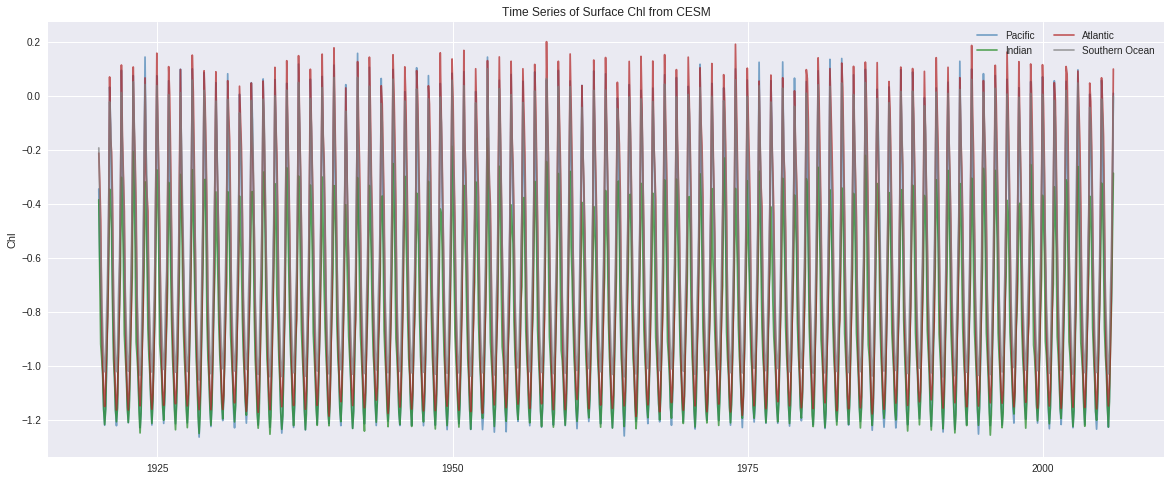

In [143]:
# Plot all Basins
fig = plt.figure(figsize=(20,8))

ax = fig.add_subplot(111)
ax.set_title('Time Series of Surface Chl from CESM')

ax.plot(chl_pac_mean['time'].values, np.log10(chl_pac_mean.values), alpha=0.7, label = 'Pacific', color = "steelblue")
ax.plot(chl_ind_mean['time'].values, np.log10(chl_ind_mean.values), alpha=0.7, label = 'Indian', color = "forestgreen")
ax.plot(chl_atl_mean['time'].values, np.log10(chl_atl_mean.values), alpha=0.7, label = 'Atlantic', color = "firebrick")
ax.plot(chl_so_mean['time'].values, np.log10(chl_so_mean.values), alpha=0.7, label = 'Southern Ocean', color = "grey")

ax.legend(ncol=2)
ax.set(ylabel='Chl')
plt.gca()

#plt.savefig('CESM-CHL-TIMESERIES-BYBASIN.png')

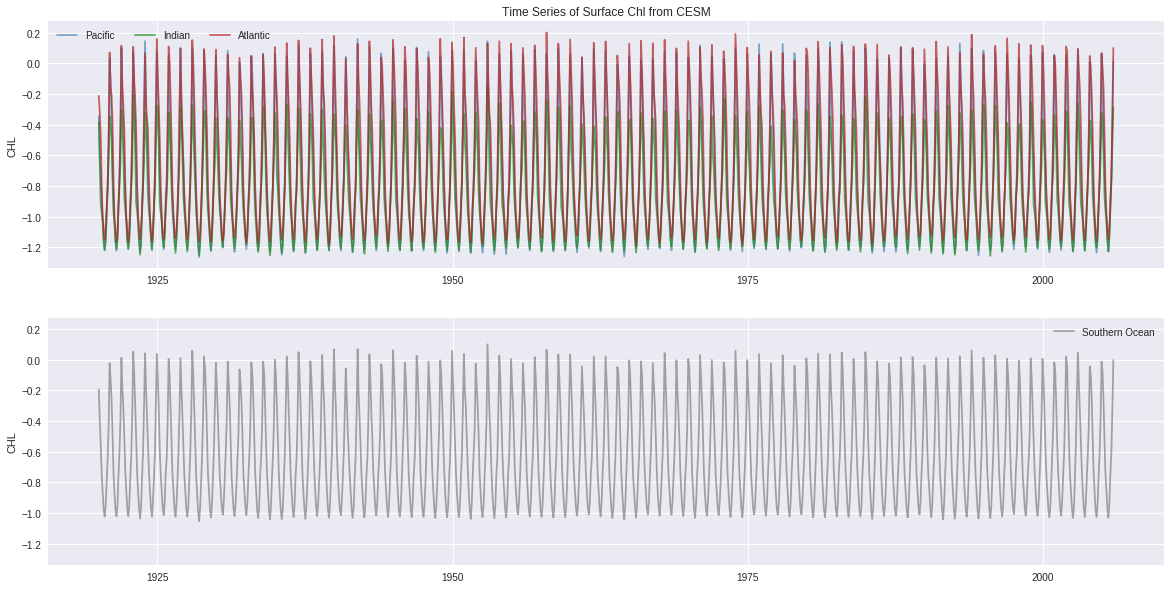

In [147]:
# Plot all Basins
style.use('seaborn')

fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(211)
ax1.set_title('Time Series of Surface Chl from CESM')

ax1.plot(chl_pac_mean['time'].values, np.log10(chl_pac_mean.values), alpha=0.7, label = 'Pacific', color = "steelblue" )
ax1.plot(chl_ind_mean['time'].values, np.log10(chl_ind_mean.values), alpha=0.7, label = 'Indian', color = "forestgreen")
ax1.plot(chl_atl_mean['time'].values, np.log10(chl_atl_mean.values), alpha=0.7, label = 'Atlantic', color = "firebrick")

ax1.legend(ncol=3)
ax1.set(ylabel='CHL')
plt.gca()

ax2 = fig.add_subplot(212, sharex=ax1, sharey=ax1 )
ax2.plot(chl_so_mean['time'].values, np.log10(chl_so_mean.values), alpha=0.7, label = 'Southern Ocean', color = "grey")
ax2.legend()
ax2.set(ylabel='CHL')
plt.gca()

#plt.savefig('CESM-CHL-TIMESERIES-BYBASIN-SOsepate.png')

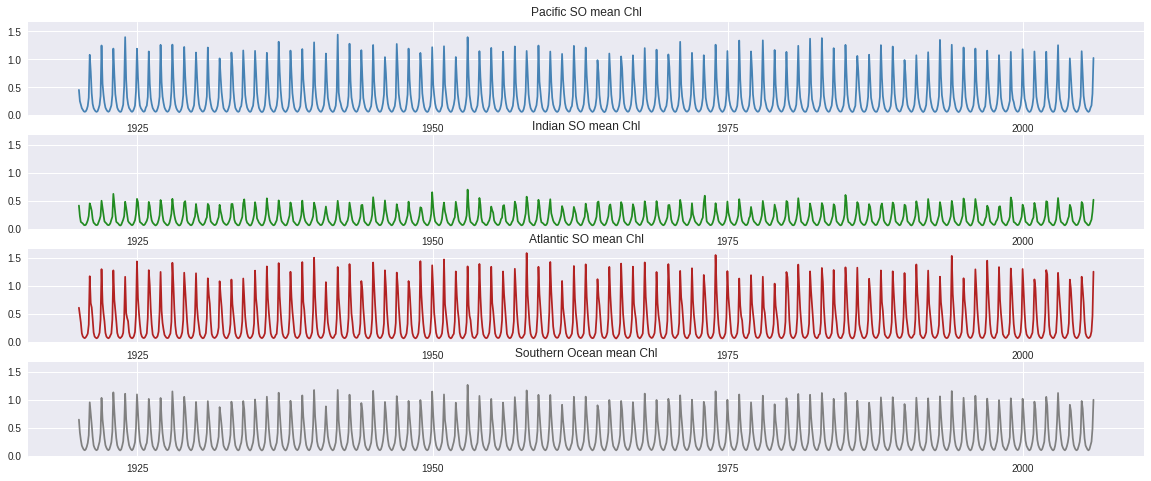

In [145]:
# Plot all Basins
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(411)
ax1.set_title('Pacific SO mean Chl')
ax1.plot(chl_pac_mean['time'].values, chl_pac_mean.values, color = 'steelblue')
plt.gca()

ax2 = fig.add_subplot(412,sharex=ax1, sharey=ax1 )
ax2.set_title('Indian SO mean Chl')
ax2.plot(chl_ind_mean['time'].values, chl_ind_mean.values, color = 'forestgreen')
plt.gca()


ax3 = fig.add_subplot(413,sharex=ax1, sharey=ax1)
ax3.set_title('Atlantic SO mean Chl')
ax3.plot(chl_atl_mean['time'].values, chl_atl_mean.values, color = 'firebrick')
plt.gca()

ax3 = fig.add_subplot(414, sharex=ax1, sharey=ax1)
ax3.set_title('Southern Ocean mean Chl')
ax3.plot(chl_so_mean['time'].values, chl_so_mean.values, color = 'grey')
plt.gca()

#plt.savefig('CESM-CHL-TIMESERIES-BYBASIN-INDIVID.png')

In [150]:
cluster.close()
client.close()